## Final Outcome: 
1. How many cell-types are in your dataset?
2. Which marker genes characterize the cell-types?
3. What cell-types are likely present?

#### Make sure to include:
1. Dataset details (nb cells, nb detected genes, qc plots such as boxplot of avg. nb of genes expressed per cell, …)
2. Results (answering the main questions, include standard plots to visualize your results (t-SNE, UMAP, clustering, expression of marker genes, …)



In [189]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import warnings
warnings.filterwarnings("ignore")

In [190]:
df = pd.read_csv('data/7_ovary.tsv', sep='\t', header=None)

In [191]:
df.set_index(df.columns[0], inplace=True)

In [192]:
df

,1,2,3,4,5,6,7,8,9,10,...,7540,7541,7542,7543,7544,7545,7546,7547,7548,7549
0,,,,,,,,,,,,,,,,,,,,,
128up,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14-3-3epsilon,1,0,2,2,1,1,2,0,3,0,...,0,4,1,0,0,0,1,3,4,0
14-3-3zeta,1,2,1,2,1,0,3,0,3,8,...,2,5,3,3,1,1,0,2,8,6
140up,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18SrRNA-Psi:CR41602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zormin,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zpg,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
zuc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [193]:
adata = sc.AnnData(df.T)
adata

AnnData object with n_obs × n_vars = 7549 × 11944

the dataset has the shape barcodes (cells) x number of transcripts

## Quality control analysis 














#### QC = Quality control analysis
1. The number of counts per barcode (count depth)
2. The number of genes per barcode 
3. THe fraction of counts from mitochondrial genes per barcode. 


Low quality cells might show a low count depth, few detected genes and a high fraction of mitochondrial reads. Important to consider 3 QC covariates jointly. Similar to [Germain et al., 2020], we mark cells as outliers if they differ by 5 MADs which is a relatively permissive filtering strategy. We want to highlight that it might be reasonable to re-assess the filtering after annotation of cells. 

 Usually, studies us data-agnostic QC filters, set at 5-10% for fraction of mitochondrial reads, 500 for gene complexity. 



Ref: 
1. Subramanian, A., Alperovich, M., Yang, Y. et al. Biology-inspired data-driven quality control for scientific discovery in single-cell transcriptomics. Genome Biol 23, 267 (2022). https://doi.org/10.1186/s13059-022-02820-w
2. https://www.sc-best-practices.org


In [194]:
#QC 
adata.var['mt'] = adata.var_names.str.startswith('mt:')  # annotate the group of mitochondrial genes as 'mt'
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=[20], log1p=True, inplace=True)


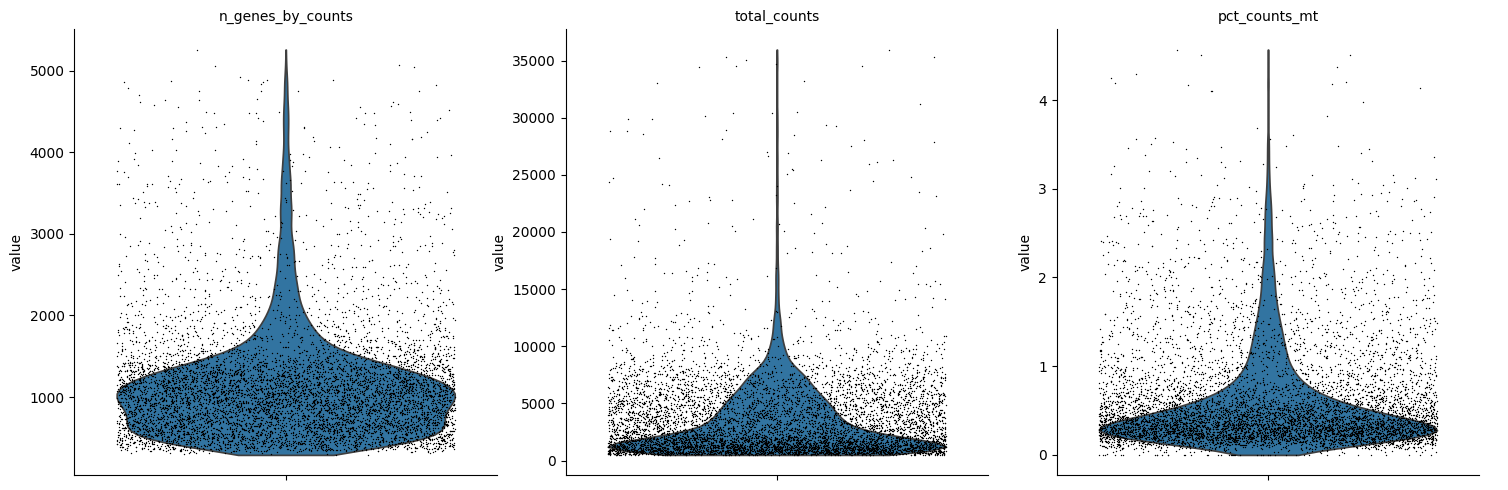

In [195]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


1. n_genes_by_counts: number of genes with positive counts in a cell
2. total_counts: total number of counts for a cell = library size 
3. pct_counts_mt: proportion of total counts for a cell which are mitochondrial 

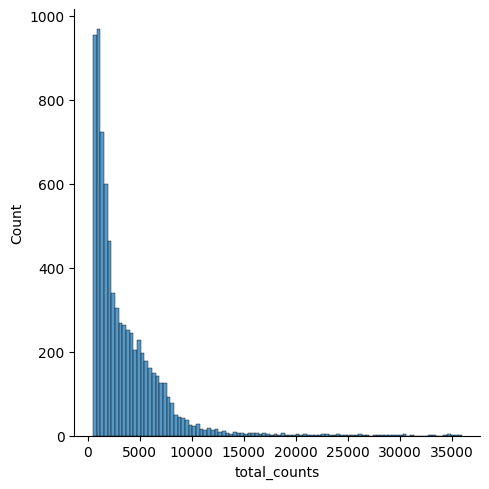

In [196]:
sns.displot(adata.obs["total_counts"], bins=100, kde=False)

Power-law distribution. The majority of cells have <2500 counts 

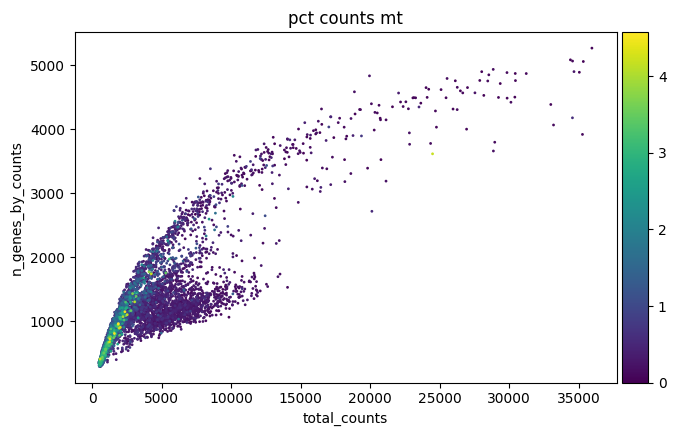

In [197]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Low complexity of genes and high mitochondrial read content have been used as a proxy for identifying poor-quality cells . High gene complexity has been used as a proxy for doublets or multiplets in droplet-based sequencing.

### Identifiying Outliers

Because we don't want to filter out too much, we first perform a basic qc with high quality cells defined as >= 100 genes, >= 3 cells <= 80% mito. We will calculate median absolute deviation (MAD) based thresholds after dimensionality reduction and clustering for each cluster

In [198]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs["pct_counts_mt"] <= 1, :]

In [199]:
adata

View of AnnData object with n_obs × n_vars = 6345 × 11218
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

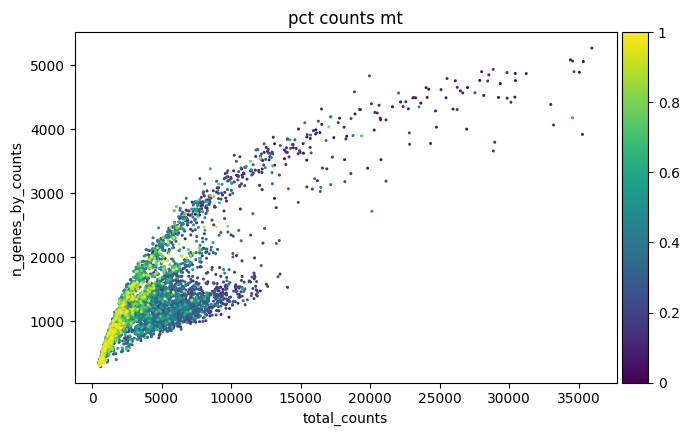

In [200]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Using MAD:

In [201]:
''' def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (np.median(M) + nmads * median_abs_deviation(M) < M)
    return outlier

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 8 )
adata.obs.mt_outlier.value_counts()

print(f"Total number of cells: {adata.n_obs}")
adata_filterted = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata_filterted.n_obs}")
'''

' def is_outlier(adata, metric: str, nmads: int):\n    M = adata.obs[metric]\n    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (np.median(M) + nmads * median_abs_deviation(M) < M)\n    return outlier\n\nadata.obs["outlier"] = (\n    is_outlier(adata, "log1p_total_counts", 5)\n    | is_outlier(adata, "log1p_n_genes_by_counts", 5)\n    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)\n)\nadata.obs.outlier.value_counts()\n\nadata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 8 )\nadata.obs.mt_outlier.value_counts()\n\nprint(f"Total number of cells: {adata.n_obs}")\nadata_filterted = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()\n\nprint(f"Number of cells after filtering of low quality cells: {adata_filterted.n_obs}")\n'

### Normalization 
Normalize the feature expression measurements for each cell by the total expression, multiply by a scale factor (10,000) and log-transfrom the result to get log(TPX + 1) values

In [202]:
sc.pp.normalize_total(adata, target_sum= 1e4)

2. Log normalize: log2(1+x) => easier to compare genes with different levels of expression 

In [203]:
# Log normalize gene expression using log2(1+x) transformation
sc.pp.log1p(adata)

3. Highly Variable genes are used to compute the PCA . As PCA doesn't work well with too many features, you limit your data to highly variable genes to compute PCA. Keep and mark the genes with the higher variance (2000 genese with most variance): compute the average + variance, keep the ones with highest variance, first 2000

In [204]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)

# Get the names of the most variable genes
highly_variable_genes = adata[:, adata.var.highly_variable]

# Print the names of the 2000 most variable genes
print("Names of the 2000 most variable genes:")
highly_variable_genes.var

Names of the 2000 most variable genes:


,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
0,,,,,,,,,,,,,
28SrRNA-Psi:CR40596,False,False,524,0.080408,0.077339,93.058683,607,6.410175,524,True,0.236907,1.940362,0.900982
28SrRNA-Psi:CR45848,False,False,20,0.002914,0.002910,99.735064,22,3.135494,20,True,0.008041,1.934334,0.888259
2mit,False,False,70,0.009538,0.009492,99.072725,72,4.290459,70,True,0.051481,2.003145,1.033499
5-HT1A,False,False,4,0.000662,0.000662,99.947013,5,1.791759,4,True,0.003793,2.049678,1.131715
5-HT1B,False,False,7,0.000927,0.000927,99.907272,7,2.079442,7,True,0.006222,2.141395,1.325302
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zfh1,False,False,818,0.348920,0.299305,89.164128,2634,7.876638,818,True,0.565772,3.698479,3.601182
zfh2,False,False,250,0.044774,0.043801,96.688303,338,5.826000,250,True,0.105849,2.263347,1.582707
zld,False,False,1167,0.359650,0.307228,84.540999,2715,7.906915,1167,True,0.542904,2.304330,1.249246


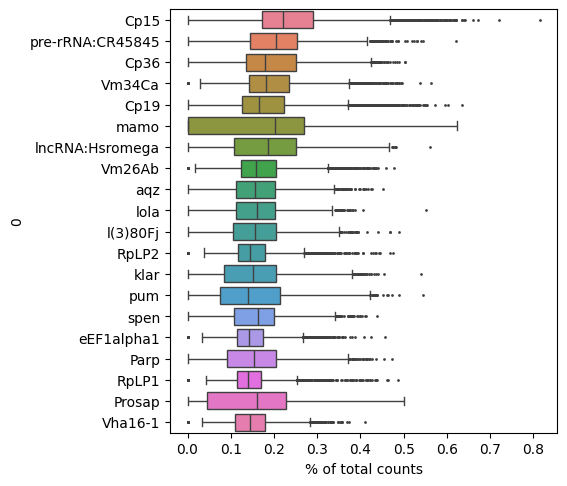

In [205]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [206]:
adata

AnnData object with n_obs × n_vars = 6345 × 11218
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Dimensionality reduction


### PCA

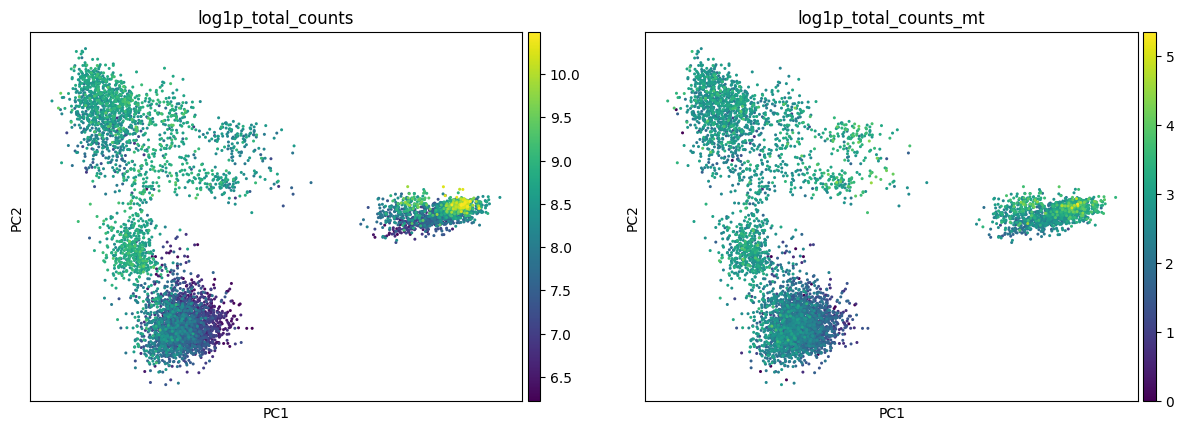

In [207]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
sc.pl.pca(adata,color=['log1p_total_counts','log1p_total_counts_mt'])


In [208]:
adata

AnnData object with n_obs × n_vars = 6345 × 11218
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### UMAP 



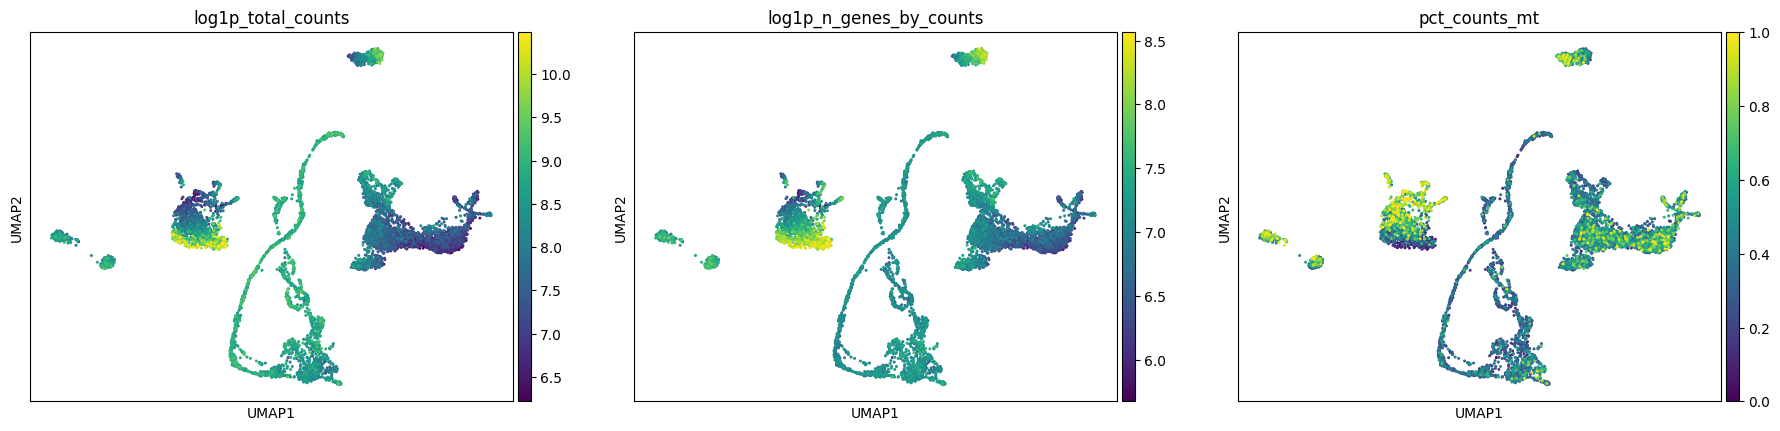

In [209]:
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.pl.umap(adata, color=['log1p_total_counts','log1p_n_genes_by_counts','pct_counts_mt'])

## Clustering 

In [210]:
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)
sc.tl.leiden(adata, key_added="leiden_res2", resolution=2)


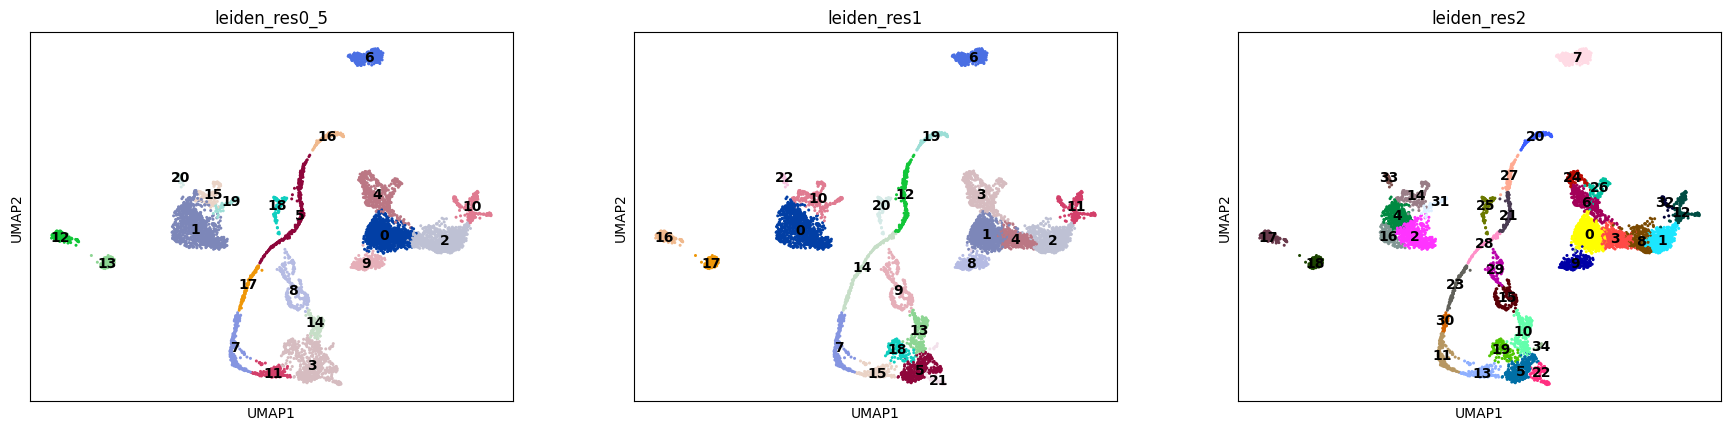

In [211]:
sc.pl.umap(adata, color=["leiden_res0_5", "leiden_res1","leiden_res2"],legend_loc="on data",);

### QC on clusters ?

## Cell annotation

### Differential expression analysis

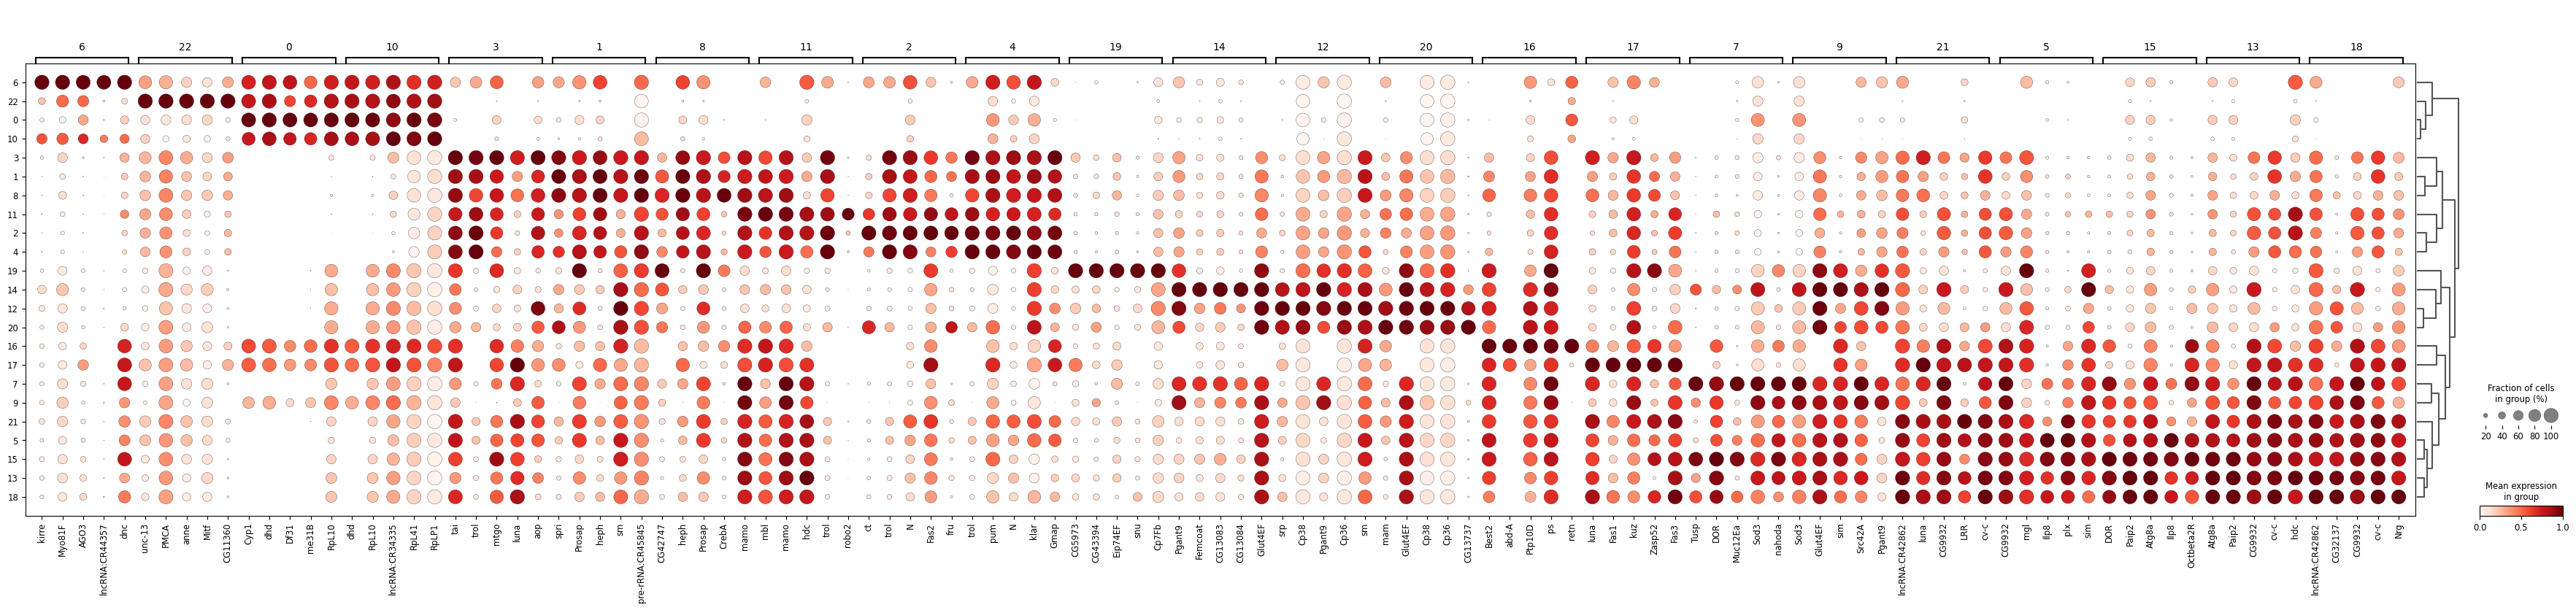

In [212]:
#calculate the differentially expressed genes for every cluster, compared to the rest of the cells in our adata 
sc.tl.rank_genes_groups(adata, groupby="leiden_res1", method="t-test", key_added="dea_leiden_1")

#Visualize:
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden_res1", standard_scale="var", n_genes=5, key="dea_leiden_1")


In [213]:
# filter the differentially expressed genes to select for more cluster-specific differentially expressed genes:
sc.tl.filter_rank_genes_groups(adata, key="dea_leiden_1", min_in_group_fraction=0.2, max_out_group_fraction=0.2, key_added="dea_leiden_1_filtered")

#Visualise: 


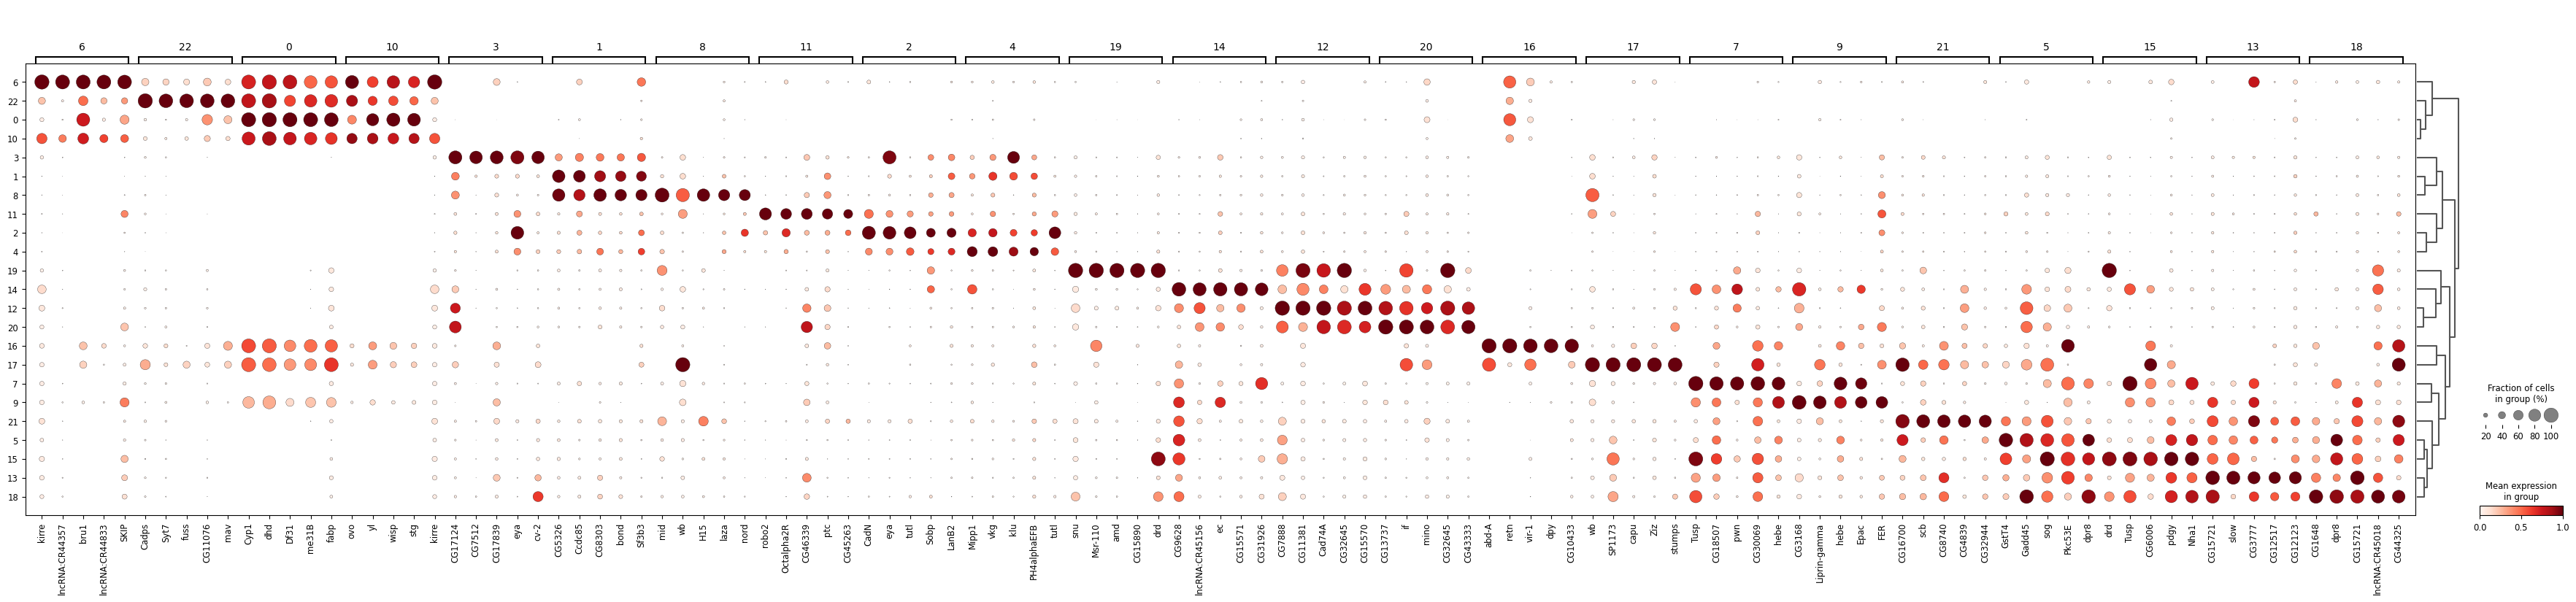

In [215]:
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden_res1", standard_scale="var", n_genes=5, key="dea_leiden_1_filtered")

In [218]:
markers = pd.DataFrame(adata.uns["dea_leiden_1_filtered"]["names"])

### Identify cell types
Use the Fly Cell Atlas ovaries dataset: https://flycellatlas.ds.czbiohub.org/ovary/

### (Remove noise + covariates)
1. External: Batch Effect Correction => use an integration method . Do not to that if you have two libraries with different conditions (the signal from treatment overlaps with the batch signal)
2. Cell cycle = huge covariate: score the cells according to genes expressed in different phases => hue by the phase . You can either keep the cells in mitosis and analyze them separetly from G1 or you just keep G1